# <font color ='blue'>Predicting diabetes occurrence</font>

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. This dataset is also know as PIMA Indians Diabetes, and its objective is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.

The predictor variables are the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. This dataset could also be found in the UCI Machine Learning Repository, however it is no longer available there.

References:

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

https://www.kaggle.com/uciml/pima-indians-diabetes-database
https://archive.ics.uci.edu/ml/index.html

In [1]:
# Import packages
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', 300)

In [2]:
# Load data into pandas dataframes
data = pd.read_csv('datasets/diabetes.csv')

In [3]:
data.head(3).append(data.tail(3))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
def check_missing(dataset, display = 5):
    temp_df = dataset.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Great! There are no missing values in this dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)
check_missing(data,7)

Great! There are no missing values in this dataset.


In [7]:
# Compute the number of occurrences of a zero value 
def check_zeros(dataset):
    temp_df = dataset.copy(); n_total = temp_df.shape[0]; idcol = []; counter = []; zeros_data = []
    features = [c for c in dataset.columns if c not in ['Outcome']]
    for col in features:
        zeros_count = n_total - np.count_nonzero(temp_df[col])
        idcol.append(col)
        counter.append(zeros_count)
        zeros_data.append(zeros_count / n_total * 100)
    zeros_data = pd.DataFrame({'Zero amount': counter,'% Zero' : zeros_data})
    zeros_data.index = idcol
    return zeros_data.sort_values('% Zero', ascending = False).head(6)
check_zeros(data)

,% Zero,Zero amount
Insulin,48.697917,374
SkinThickness,29.557292,227
Pregnancies,14.453125,111
BloodPressure,4.557292,35
BMI,1.432292,11
Glucose,0.651042,5


In [8]:
# Transform zero values found into NAN so they can be treated
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[col].replace(0, np.nan, inplace = True)
check_missing(data,7)

,% Missing,Missing n
Insulin,48.697917,374
SkinThickness,29.557292,227
BloodPressure,4.557292,35
BMI,1.432292,11
Glucose,0.651042,5
Pregnancies,0.000000,0
DiabetesPedigreeFunction,0.000000,0


In [9]:
glucose_0 = data.loc[data['Outcome'] == 0,'Glucose'].mean()
glucose_1 = data.loc[data['Outcome'] == 1,'Glucose'].mean()
bp_0 = data.loc[data['Outcome'] == 0,'BloodPressure'].mean()
bp_1 = data.loc[data['Outcome'] == 1,'BloodPressure'].mean()
skin_0 = data.loc[data['Outcome'] == 0,'SkinThickness'].mean()
skin_1 = data.loc[data['Outcome'] == 1,'SkinThickness'].mean()
ins_0 = data.loc[data['Outcome'] == 0,'Insulin'].mean()
ins_1 = data.loc[data['Outcome'] == 1,'Insulin'].mean()
bmi_0 = data.loc[data['Outcome'] == 0,'BMI'].mean()
bmi_1 = data.loc[data['Outcome'] == 1,'BMI'].mean()

data.loc[(data['Outcome'] == 0) & (data['Glucose'].isnull() == True),'Glucose'] = glucose_0
data.loc[(data['Outcome'] == 1) & (data['Glucose'].isnull() == True),'Glucose'] = glucose_1
data.loc[(data['Outcome'] == 0) & (data['BloodPressure'].isnull() == True),'BloodPressure'] = bp_0
data.loc[(data['Outcome'] == 1) & (data['BloodPressure'].isnull() == True),'BloodPressure'] = bp_1
data.loc[(data['Outcome'] == 0) & (data['SkinThickness'].isnull() == True),'SkinThickness'] = skin_0
data.loc[(data['Outcome'] == 1) & (data['SkinThickness'].isnull() == True),'SkinThickness'] = skin_1
data.loc[(data['Outcome'] == 0) & (data['Insulin'].isnull() == True),'Insulin'] = ins_0
data.loc[(data['Outcome'] == 1) & (data['Insulin'].isnull() == True),'Insulin'] = ins_1
data.loc[(data['Outcome'] == 0) & (data['BMI'].isnull() == True),'BMI'] = bmi_0
data.loc[(data['Outcome'] == 1) & (data['BMI'].isnull() == True),'BMI'] = bmi_1

check_missing(data,7)

Great! There are no missing values in this dataset.


In [10]:
print(data[data.SkinThickness > 60]['SkinThickness'])

445    63.0
579    99.0
Name: SkinThickness, dtype: float64


In [11]:
data['SkinThickness'].iloc[579] = data['SkinThickness'].mean()

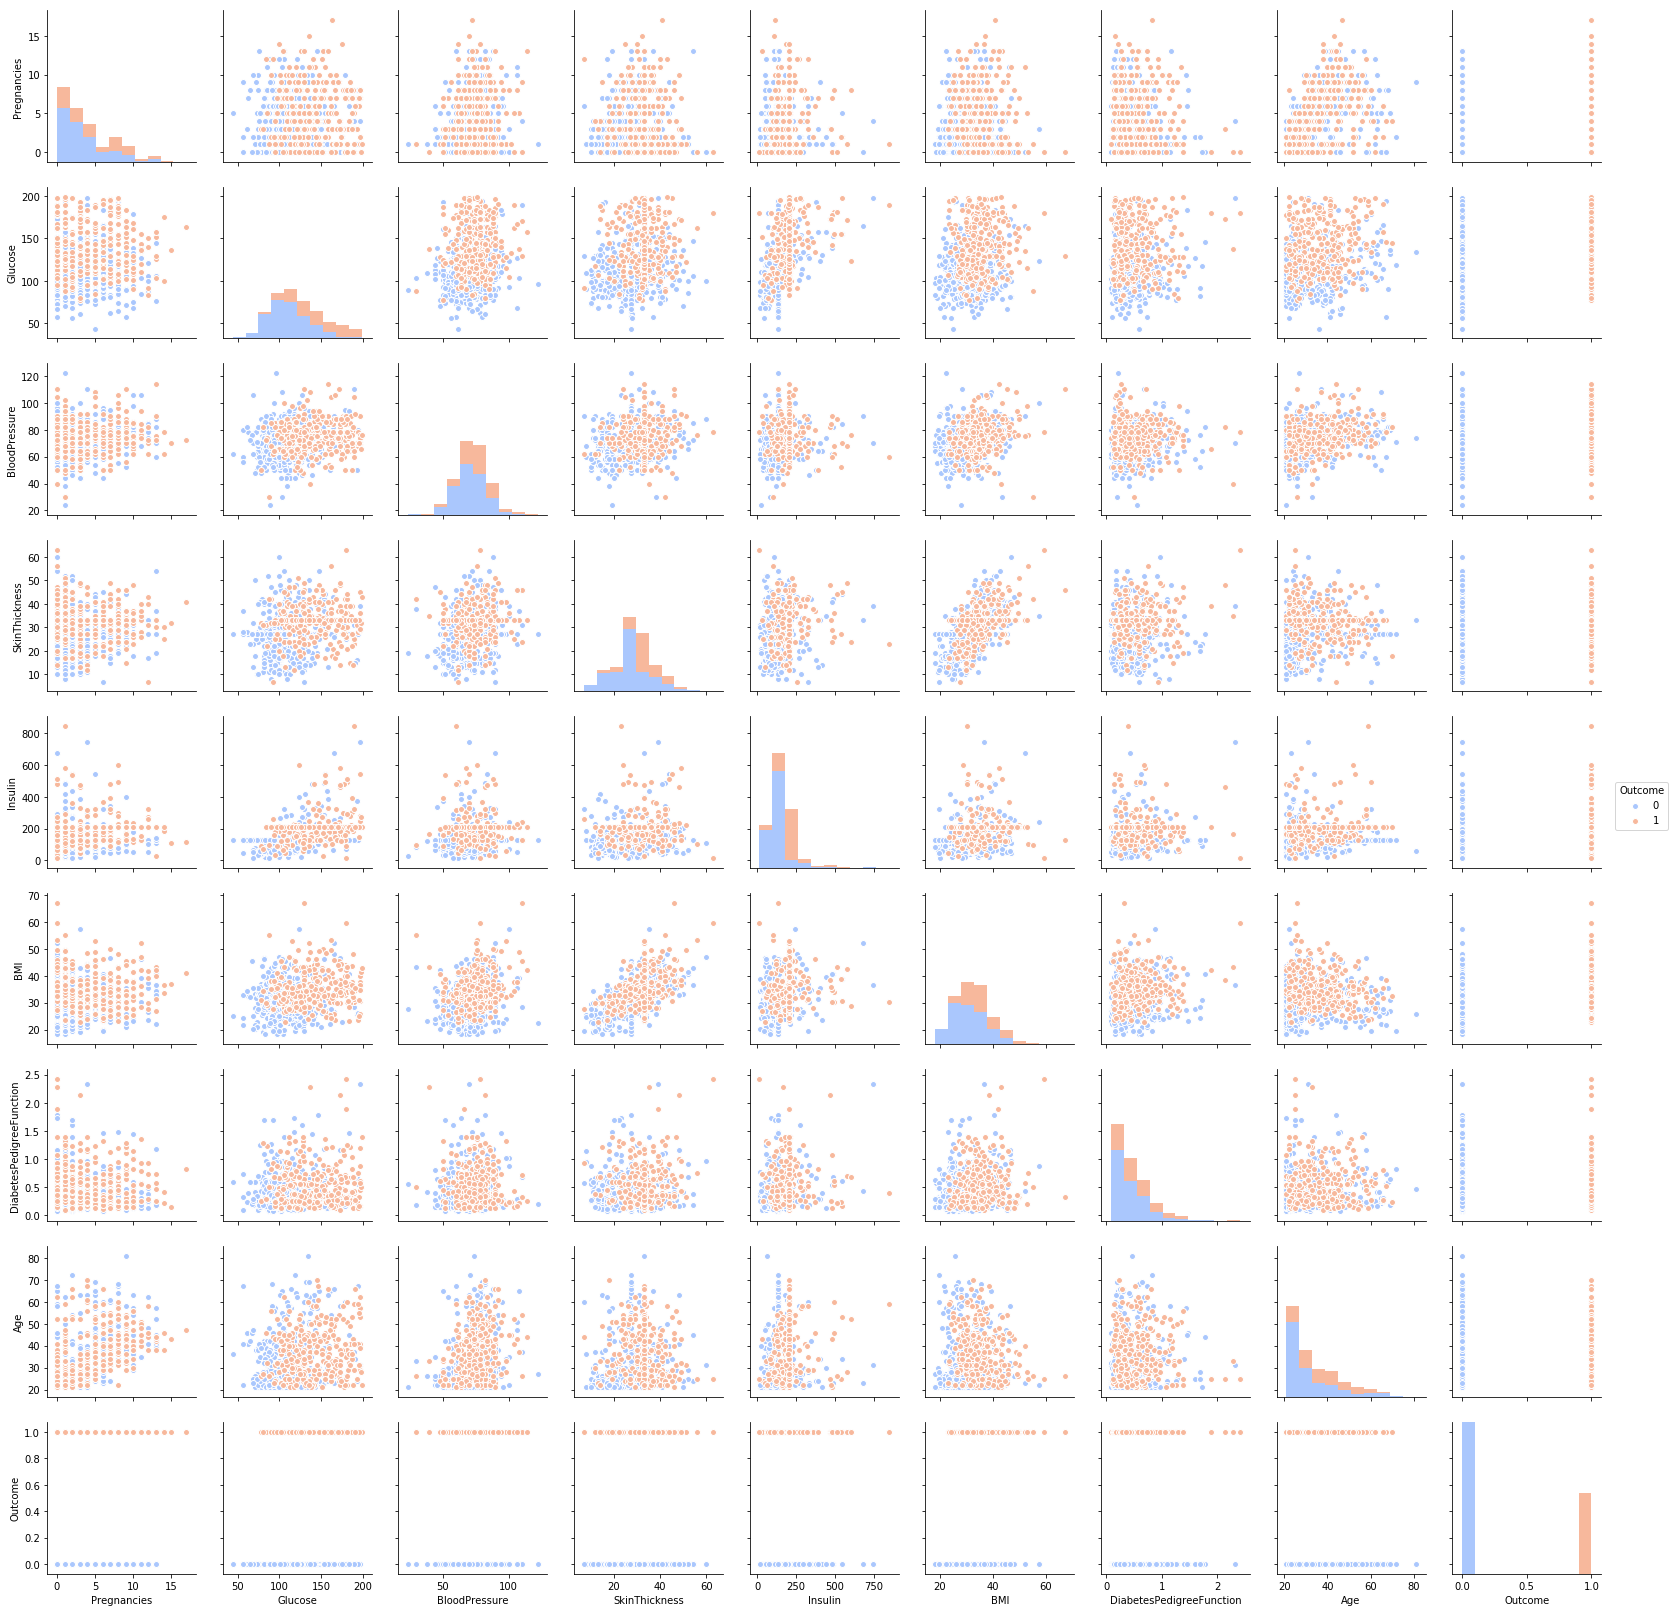

In [12]:
sns.pairplot(data, hue ='Outcome',palette ='coolwarm')

Pregnancies                    AxesSubplot(0.125,0.657941;0.227941x0.222059)
Glucose                     AxesSubplot(0.398529,0.657941;0.227941x0.222059)
BloodPressure               AxesSubplot(0.672059,0.657941;0.227941x0.222059)
SkinThickness                  AxesSubplot(0.125,0.391471;0.227941x0.222059)
Insulin                     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
BMI                         AxesSubplot(0.672059,0.391471;0.227941x0.222059)
DiabetesPedigreeFunction          AxesSubplot(0.125,0.125;0.227941x0.222059)
Age                            AxesSubplot(0.398529,0.125;0.227941x0.222059)
Outcome                        AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

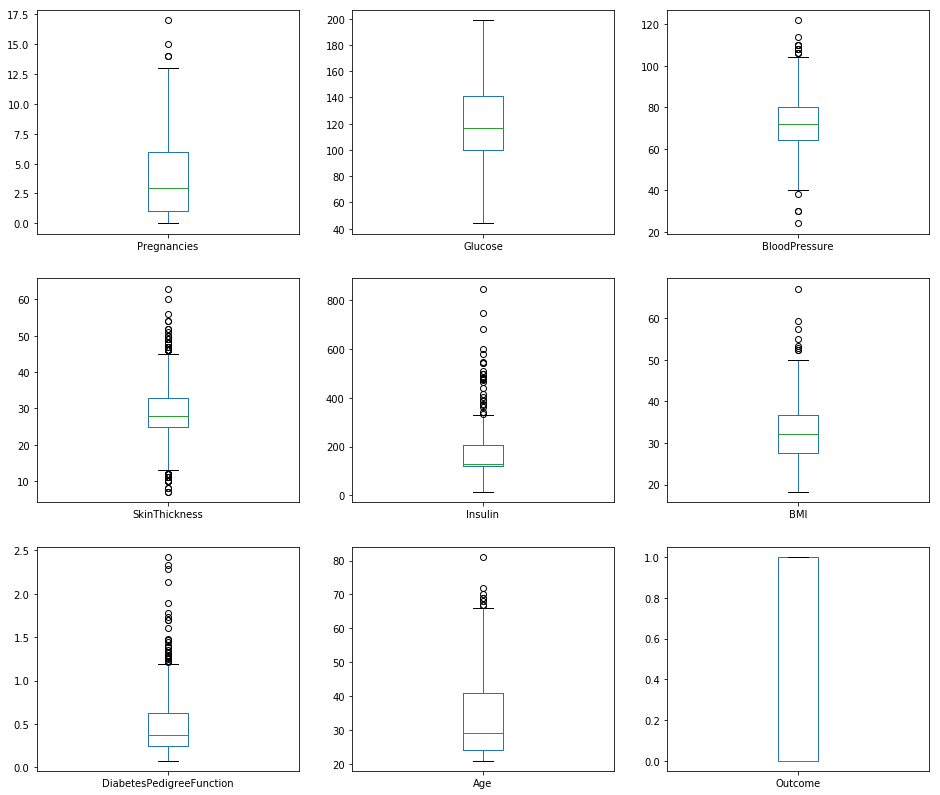

In [13]:
data.plot(kind = 'box', subplots = True, layout = (3,3), figsize = (16,14))

Class 0: 500 (65.1%)
Class 1: 268 (34.9%)


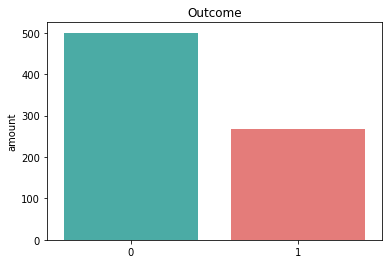

In [14]:
# Function to check the output variable
def check_output(dataset, output):
    amount = dataset[output].value_counts()
    ratio =  dataset[output].value_counts(normalize = True)*100
    print('Class 0: {} ({}%)'.format(amount[0], round(ratio[0],2)))
    print('Class 1: {} ({}%)'.format(amount[1], round(ratio[1],2)))

    labels = ['1' if label == 1 else '0' for label in dataset[output]]
    palette = {'1': '#f56b69', '0': '#3bbbb3'}

    ax = sns.countplot(labels, palette=palette)
    plt.title(output)
    plt.ylabel('amount')
    return plt.show()

check_output(data, 'Outcome')

In [15]:
from imblearn.over_sampling import SMOTE

new_X, new_y = SMOTE().fit_sample(data, data.Outcome)

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(new_X)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, new_y, test_size = 0.20, random_state = 42)

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion matrix: \n', confusion_matrix(y_test,pred))
print('\n\n Classification Report: \n', classification_report(y_test,pred))

Confusion matrix: 
 [[ 99   0]
 [  0 101]]


 Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00       101

   micro avg       1.00      1.00      1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

